## Import and define dependencies

In [285]:
# standard library
from pathlib import Path
from typing import Any


# dependencies
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from numpy.typing import NDArray
from sklearn.decomposition import TruncatedSVD


# constants
DATA = Path().resolve().parents[1] / "data"
DIMS = "t", "ch"
DTYPE = [
    ("time", "a28"),
    ("reserved1", "a4"),
    ("obsnum", "i8"),
    ("scantype", "a8"),
    ("scanmode", "a8"),
    ("chopperpos", "a8"),
    ("scancount", "i8"),
    ("speccount", "i8"),
    ("integtime", "i4"),
    ("reserved2", "a172"),
    ("array", ("f4", 32768)),
]
T_AMB = 273.0 # K
T_INTEG = 0.2 # s


# load function
def dB(da: xr.DataArray) -> xr.DataArray:
    return 10 * np.log10(da)


def load(xffts: Path, ch_average: int = 8) -> xr.DataArray:
    """Load an XFFTS binary dataset into a DataArray."""
    with open(xffts, "rb") as f:
        log = np.frombuffer(f.read(), dtype=DTYPE)

    return xr.DataArray(
        data=average_channels(log["array"], ch_average),
        dims=DIMS,
        coords={"t": np.array([t[:24] for t in log["time"]], "M8[ns]")},
    )

def average_channels(array: NDArray[Any], size=2) -> NDArray[Any]:
    """Perform channel averaging of an array."""
    shape = array.shape[0], int(array.shape[1] / size), size
    return array.reshape(shape).mean(2)


def assign_onoff(da: xr.DataArray, f_switching: float = 1.0) -> xr.DataArray:
    """Assign ON and OFF to a DataArray at a switching frequency."""
    # dwell time per position
    t_dwell = 1 / f_switching # s

    # number of samples per position
    ns_dwell = int(np.floor(t_dwell / T_INTEG))

    # number of sampler per cycle
    ns_cycle = 2 * ns_dwell

    # number of switching cycles
    n_cycle = int(np.ceil(len(da) / ns_cycle))

    cycle = np.repeat(np.arange(n_cycle), ns_cycle)
    intent = np.tile(np.repeat(["ON", "OFF"], ns_dwell), n_cycle)

    return da.assign_coords({
        "cycle": ("t", cycle[:len(da)]),
        "intent": ("t", intent[:len(da)]),
    })


@np.vectorize
def allan_variance(data: np.ndarray, tau: int) -> float:
    """Calculate Allan variance (AVAR).

    Args:
        data: Input (non-averaged) samples.
        tau: Averaging interval.

    Returns:
        avar: Allan variance.

    """
    data = data[len(data) % tau:]
    y = data.reshape(len(data) // tau, tau).mean(axis=1)
    return (np.diff(y) ** 2).sum() / (2 * (len(y) - 1))


allan_variance.excluded.add(0)


## Load R and SKY datasets with channel averaging

In [276]:
ch_average = 16
P_sky = load(DATA / "xffts20181007151213.xfftsx.01", ch_average)[:, 24:-24]
P_cal = load(DATA / "xffts20181007152116.xfftsx.01", ch_average)[:, 24:-24]

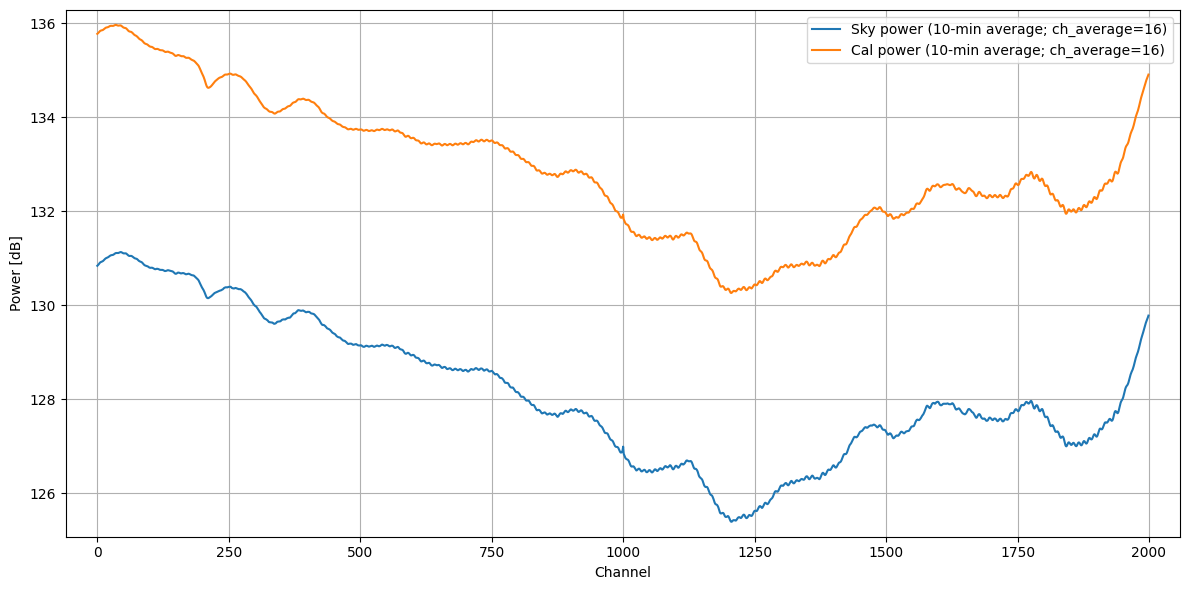

In [277]:
fig, ax = plt.subplots(figsize=(12, 6))

dB(P_sky.mean("t")).plot(ax=ax, label=f"Sky power (10-min average; {ch_average=})")
dB(P_cal.mean("t")).plot(ax=ax, label=f"Cal power (10-min average; {ch_average=})")
ax.set_xlabel("Channel")
ax.set_ylabel("Power [dB]")
ax.margins(0.03)
ax.legend()
ax.grid(True)

fig.tight_layout()

## PSW and GoDec simulations

In [344]:
f_switching = 1.0
P_sky_sim = assign_onoff(P_sky, f_switching)

In [345]:
def func(da: xr.DataArray) -> xr.DataArray:
    on = da[da.intent == "ON"]
    off = da[da.intent == "OFF"]

    return (on - off.mean("t")) / off.mean("t")

T_sys = T_AMB / (P_cal.mean("t") / P_sky.mean("t") - 1)
T_psw = T_sys * P_sky_sim.groupby("cycle").apply(func).dropna("t")

In [346]:
model = TruncatedSVD(10)

X = np.log(-(P_sky_sim - P_cal.mean("t")) / T_AMB)
X0 = X.mean("t")
C = model.fit_transform(X - X0)
P = model.components_
L = xr.zeros_like(P_sky_sim) + C @ P + X0

T_godec = T_AMB * (1 - np.exp(X - L))[X.intent == "ON"]

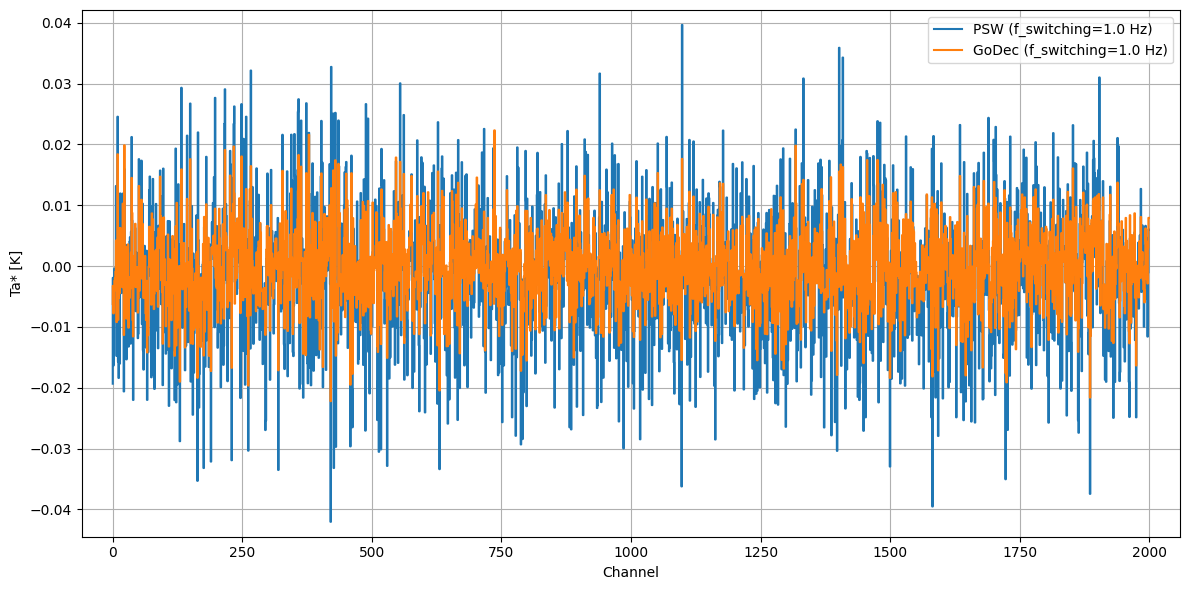

In [347]:
fig, ax = plt.subplots(figsize=(12, 6))

T_psw.mean("t").plot.step(ax=ax, label=f"PSW ({f_switching=} Hz)")
T_godec.mean("t").plot.step(ax=ax, label=f"GoDec ({f_switching=} Hz)")
ax.set_xlabel("Channel")
ax.set_ylabel("Ta* [K]")
ax.margins(0.03)
ax.legend()
ax.grid(True)

fig.tight_layout()

/tmp/ipykernel_978/1872584549.py:93: RuntimeWarning: invalid value encountered in divide
  return (np.diff(y) ** 2).sum() / (2 * (len(y) - 1))
/usr/local/lib/python3.12/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


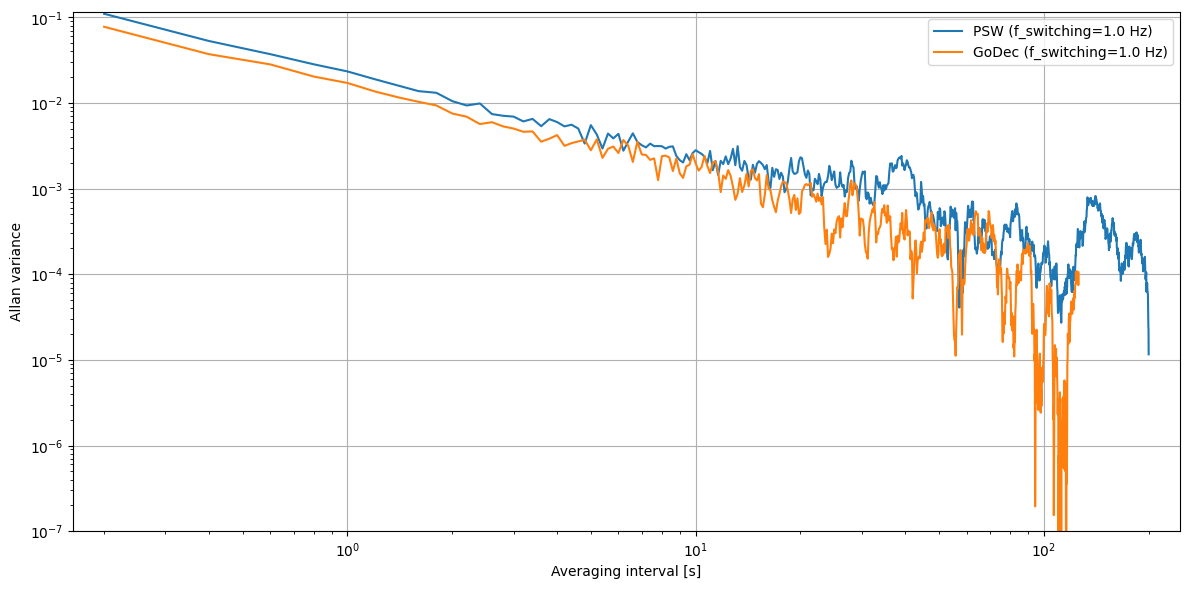

In [348]:
fig, ax = plt.subplots(figsize=(12, 6))

taus_psw = np.arange(1, len(T_psw) + 1)
tav_psw = allan_variance(T_psw[:, 1100].values, tau=taus_psw)
ax.plot(taus_psw * T_INTEG, tav_psw, label=f"PSW ({f_switching=} Hz)")
taus_godec = np.arange(1, len(T_godec) + 1)
tav_godec = allan_variance(T_godec[:, 1100].values, tau=taus_godec)
ax.plot(taus_godec * T_INTEG, tav_godec, label=f"GoDec ({f_switching=} Hz)")
ax.set_xlabel("Averaging interval [s]")
ax.set_ylabel("Allan variance")
ax.set_ylim(1e-7, None)
ax.set_xscale("log")
ax.set_yscale("log")
ax.margins(0.03)
ax.grid(True)
ax.legend()

fig.tight_layout()